In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, time
import sklearn, sklearn.metrics, sklearn.linear_model, sklearn.ensemble, sklearn.preprocessing

import modutils

data_dir = '../DataSets/Churn/'

In [2]:
src = pd.read_csv(data_dir + 'tmp_tran_last.csv')

In [3]:
src[:10]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,is_first,is_last
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20170215,20170315,0,0,0,1
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,1,20170131,20170319,0,0,0,1
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,41,30,149,149,1,20170226,20170326,0,0,0,1
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,41,30,149,149,1,20170215,20170315,0,0,0,1
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,39,30,149,149,1,20170131,20170323,0,0,0,1
5,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,14,30,149,149,1,20170131,20170304,0,0,0,1
6,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,41,30,149,149,1,20170220,20170320,0,0,0,1
7,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,38,30,149,149,0,20170224,20170326,0,0,0,1
8,++0EzISdtKY48Z0GY62jer/LFQwrNIAbADdtU5xStGY=,38,120,477,477,0,20161024,20170221,0,0,0,1
9,++0wqjjQge1mBBe5r4ciHGKwtF/m322zkra7CK8I+Mw=,41,30,99,99,1,20170206,20170306,0,0,0,1


In [4]:
metrics = {'msno':'count','is_churn':'mean','is_auto_renew':'mean','is_cancel':'mean','is_first':'mean'}

In [5]:
src.groupby('is_auto_renew').agg(metrics).sort_values('msno', ascending=False)

,msno,is_churn,is_auto_renew,is_cancel,is_first
is_auto_renew,,,,,
1,882746,0.031087,1,0.035821,0.001797
0,110185,0.326986,0,0.000000,0.107283


In [6]:
src.groupby('is_cancel').agg(metrics).sort_values('msno', ascending=False)

,msno,is_churn,is_auto_renew,is_cancel,is_first
is_cancel,,,,,
0,961310,0.040563,0.88538,0,0.013927
1,31621,0.774074,1.00000,1,0.000601


In [7]:
src.groupby(['is_auto_renew','is_cancel']).agg(metrics).sort_values('msno', ascending=False)

,,msno,is_churn,is_auto_renew,is_cancel,is_first
is_auto_renew,is_cancel,,,,,
1,0,851125,0.003484,1,0,0.001841
0,0,110185,0.326986,0,0,0.107283
1,1,31621,0.774074,1,1,0.000601


In [8]:
src.groupby(['is_first','is_auto_renew','is_cancel']).agg(metrics).sort_values('msno', ascending=False)

msno  is_churn  is_auto_renew  is_cancel  \
is_first is_auto_renew is_cancel                                               
0        1             0          849558  0.002925              1          0   
         0             0           98364  0.283579              0          0   
         1             1           31602  0.773970              1          1   
1        0             0           11821  0.688182              0          0   
         1             0            1567  0.306318              1          0   
                       1              19  0.947368              1          1   

                                  is_first  
is_first is_auto_renew is_cancel            
0        1             0                 0  
         0             0                 0  
         1             1                 0  
1        0             0                 1  
         1             0                 1  
                       1                 1

In [11]:
src['combined_3features'] = src.is_first.astype(str)+src.is_auto_renew.astype(str)+src.is_cancel.astype(str)
(f3_gini, f3_acc, f3_lloss, f3_illoss) = modutils.calcBinClassMetrics_Discrete(src.combined_3features.values.reshape(-1,1), src.is_churn)
print('Gini = {0:.3f}, Accuracy = {1:.3f}, Log-Loss-Class = {2:.3f}'.format(f3_gini, f3_acc, f3_illoss))

Gini = 0.907, Accuracy = 0.958, Log-Loss-Class = 1.450


In [27]:
conv_to_date = lambda x: datetime.date(x // 10000, (x // 100) % 100, x % 100)

src['dt_exp'] = src.membership_expire_date.map(conv_to_date)
src['dt_tran'] = src.transaction_date.map(conv_to_date)
src['dt_diff'] = (src.dt_exp - src.dt_tran).map(lambda x: x.days)
src['dt_tran_wd'] = src.dt_tran.map(lambda x: x.weekday())
src['dt_exp_wd'] = src.dt_exp.map(lambda x: x.weekday())
src['dt_tran_diff'] = (src.dt_tran.max() - src.dt_tran).map(lambda x: x.days)
src['dt_exp_diff'] = (src.dt_exp.max() - src.dt_exp).map(lambda x: x.days)

#majority is recurring customer with auto-renewal and who won't cancel
src_maj = src[(src.is_first==0)&(src.is_auto_renew==1)&(src.is_cancel==0)].copy()
src_man = src[(src.is_first==0)&(src.is_auto_renew==0)&(src.is_cancel==0)].copy()

#2-level dichotomy:
src_man30 = src_man[src_man.payment_plan_days==30].copy()

## Majority analysis

In [ ]:
src_maj.describe()
#payment plan days is 

In [ ]:
src_maj.groupby('payment_method_id').agg({'msno':'count','is_churn':'mean'}).sort_values('msno', ascending=False)

In [ ]:
src_maj.groupby('plan_list_price').agg({'msno':'count','is_churn':'mean'}).sort_values('msno', ascending=False)

In [ ]:
src_maj[src_maj.plan_list_price==99].describe()

## Manual payment, no cancel analysis (2nd largest group)

In [ ]:
src_man.describe()

In [ ]:
src_man.groupby('payment_method_id').agg({'msno':'count','is_churn':'mean'}).sort_values('msno', ascending=False)

In [ ]:
src_man.groupby('payment_plan_days').agg({'msno':'count','is_churn':'mean'}).sort_values('msno', ascending=False)

In [ ]:
src_man.groupby('plan_list_price').agg({'msno':'count','is_churn':'mean'}).sort_values('msno', ascending=False)

## Manual payment, no cancel & 30-day payment plan analysis

In [29]:
src_man30.describe()
#consts:plan days, auto_renew, cancel
#analyze: payment_method_id, price, paid, dates

#results:
#payment methods does not differentiate churn-rate
#actual_price = plan_price, except for 2 cases

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,is_first,is_last,dt_diff,dt_tran_wd,dt_exp_wd,dt_tran_diff,dt_exp_diff
count,83190.000000,83190.0,83190.000000,83190.000000,83190.0,8.319000e+04,8.319000e+04,83190.0,83190.000000,83190.0,83190.0,83190.000000,83190.000000,83190.000000,83190.00000,83190.000000
mean,36.317394,30.0,160.497800,160.497824,0.0,2.017006e+07,2.017027e+07,0.0,0.236663,0.0,1.0,31.444753,3.073410,2.920387,22.95830,22.513547
std,2.928872,0.0,16.086566,16.086516,0.0,1.109763e+03,3.675462e+02,0.0,0.425036,0.0,0.0,11.182898,2.041794,2.027630,21.25774,17.650137
min,28.000000,30.0,0.000000,0.000000,0.0,2.015010e+07,2.015060e+07,0.0,0.000000,0.0,1.0,30.000000,0.000000,0.000000,0.00000,0.000000
25%,36.000000,30.0,149.000000,149.000000,0.0,2.017013e+07,2.017023e+07,0.0,0.000000,0.0,1.0,30.000000,1.000000,1.000000,9.00000,10.000000
50%,38.000000,30.0,149.000000,149.000000,0.0,2.017021e+07,2.017031e+07,0.0,0.000000,0.0,1.0,30.000000,3.000000,3.000000,19.00000,19.000000
75%,38.000000,30.0,180.000000,180.000000,0.0,2.017022e+07,2.017032e+07,0.0,0.000000,0.0,1.0,30.000000,5.000000,5.000000,33.00000,33.000000
max,38.000000,30.0,180.000000,180.000000,0.0,2.017023e+07,2.017033e+07,0.0,1.000000,0.0,1.0,774.000000,6.000000,6.000000,788.00000,668.000000


In [30]:
src_man30.groupby('payment_method_id').agg({'msno':'count','is_churn':'mean'}).sort_values('msno', ascending=False)
#no difference by payment method whatsoever

,msno,is_churn
payment_method_id,,
38,49526,0.237633
36,23560,0.234677
29,8184,0.237048
28,1920,0.234375


In [31]:
src_man30[src_man30.actual_amount_paid!=src_man30.plan_list_price].describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,is_first,is_last,dt_diff,dt_tran_wd,dt_exp_wd,dt_tran_diff,dt_exp_diff
count,2.0,2.0,2.0,2.0,2.0,2.0,2.000000e+00,2.0,2.0,2.0,2.0,2.000000,2.0,2.0,2.0,2.000000
mean,38.0,30.0,126.0,127.0,0.0,20151209.0,2.016116e+07,0.0,1.0,0.0,1.0,353.500000,2.0,2.0,447.0,124.500000
std,0.0,0.0,0.0,0.0,0.0,0.0,6.434672e+01,0.0,0.0,0.0,0.0,14.849242,0.0,0.0,0.0,14.849242
min,38.0,30.0,126.0,127.0,0.0,20151209.0,2.016112e+07,0.0,1.0,0.0,1.0,343.000000,2.0,2.0,447.0,114.000000
25%,38.0,30.0,126.0,127.0,0.0,20151209.0,2.016114e+07,0.0,1.0,0.0,1.0,348.250000,2.0,2.0,447.0,119.250000
50%,38.0,30.0,126.0,127.0,0.0,20151209.0,2.016116e+07,0.0,1.0,0.0,1.0,353.500000,2.0,2.0,447.0,124.500000
75%,38.0,30.0,126.0,127.0,0.0,20151209.0,2.016118e+07,0.0,1.0,0.0,1.0,358.750000,2.0,2.0,447.0,129.750000
max,38.0,30.0,126.0,127.0,0.0,20151209.0,2.016121e+07,0.0,1.0,0.0,1.0,364.000000,2.0,2.0,447.0,135.000000


In [32]:
src_man30.groupby('plan_list_price').agg({'msno':'count','is_churn':'mean'}).sort_values('msno', ascending=False)
#need to introduce flag plan price is zero
#need to check price=100

,msno,is_churn
plan_list_price,,
149,48997,0.234545
180,31702,0.234528
150,1998,0.247247
100,424,0.518868
0,46,0.847826
119,19,0.210526
126,2,1.000000
143,2,1.000000


In [35]:
src_man30[src_man30.plan_list_price==0].describe()

,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,is_first,is_last,dt_diff,dt_tran_wd,dt_exp_wd,dt_tran_diff,dt_exp_diff
count,46.0,46.0,46.0,46.0,46.0,4.600000e+01,4.600000e+01,46.0,46.000000,46.0,46.0,46.000000,46.000000,46.000000,46.000000,46.000000
mean,38.0,30.0,0.0,0.0,0.0,2.016200e+07,2.017024e+07,0.0,0.847826,0.0,1.0,61.695652,1.695652,3.891304,66.565217,35.869565
std,0.0,0.0,0.0,0.0,0.0,2.541359e+03,4.125081e+01,0.0,0.363158,0.0,0.0,14.130927,1.112945,2.089426,10.402248,10.642908
min,38.0,30.0,0.0,0.0,0.0,2.016122e+07,2.017013e+07,0.0,0.000000,0.0,1.0,30.000000,1.000000,0.000000,16.000000,5.000000
25%,38.0,30.0,0.0,0.0,0.0,2.016122e+07,2.017022e+07,0.0,1.000000,0.0,1.0,60.000000,1.000000,2.000000,69.000000,35.250000
50%,38.0,30.0,0.0,0.0,0.0,2.016122e+07,2.017022e+07,0.0,1.000000,0.0,1.0,60.000000,1.000000,5.000000,69.500000,39.500000
75%,38.0,30.0,0.0,0.0,0.0,2.016122e+07,2.017022e+07,0.0,1.000000,0.0,1.0,64.000000,2.000000,5.750000,70.000000,41.000000
max,38.0,30.0,0.0,0.0,0.0,2.017021e+07,2.017033e+07,0.0,1.000000,0.0,1.0,96.000000,6.000000,6.000000,70.000000,61.000000


In [37]:
(f_gini, _,_,_) = modutils.calcBinClassMetrics_Continuous(src_man30.dt_diff.values.reshape(-1,1), src_man30.is_churn)
print('dt_diff: {0:.3f}'.format(f_gini))
(f_gini, _,_,_) = modutils.calcBinClassMetrics_Continuous(src_man30.dt_tran_diff.values.reshape(-1,1), src_man30.is_churn)
print('dt_tran_diff: {0:.3f}'.format(f_gini))
(f_gini, _,_,_) = modutils.calcBinClassMetrics_Continuous(src_man30.dt_exp_diff.values.reshape(-1,1), src_man30.is_churn)
print('dt_exp_diff: {0:.3f}'.format(f_gini))

dt_diff: 0.232
dt_tran_diff: 0.699
dt_exp_diff: 0.624


In [87]:
src_man30['dt_tran_diff10'] = np.floor(src_man30.dt_tran_diff / 10) * 10
src_man30['dt_tran_diff100'] = np.floor(src_man30.dt_tran_diff / 100) * 100

In [120]:
Xt0 = src_man30.dt_tran_diff.values.reshape(-1,1)
Xt1 = src_man30.dt_exp_diff.values.reshape(-1,1)
Yt = src_man30.is_churn.values

Xt = np.hstack([Xt0, 1*(Xt1 <= 30), Xt1 * (Xt1 <= 30)])
#Yp = sklearn.linear_model.LogisticRegression().fit(Xt, Yt).predict_proba(Xt)[:,1]
Yp = sklearn.ensemble.GradientBoostingClassifier(min_samples_leaf=50, min_samples_split=100, max_depth=4).fit(Xt, Yt).predict_proba(Xt)[:,1]
src_man30['dt_prob'] = Yp
src_man30['dt_lgt'] = np.log(Yp/(1-Yp))

tmp = src_man30.groupby('dt_tran_diff').agg({'msno':'count', 'is_churn':'mean', 'prob':'mean'})
tmp['diff'] = (tmp.is_churn - tmp.prob) * tmp.msno
tmp[:50]

,msno,is_churn,prob,diff
dt_tran_diff,,,,
0,2078,0.000000,0.006077,-12.627301
1,1895,0.040106,0.042654,-4.829476
2,1962,0.043833,0.044814,-1.924326
3,2116,0.045841,0.046620,-1.647820
4,2018,0.055005,0.055682,-1.366599
5,1931,0.063698,0.064371,-1.301073
6,1968,0.070630,0.065087,10.908320
7,2076,0.066474,0.065087,2.878899
8,2255,0.060754,0.065087,-9.771716


In [121]:
tmp = src_man30.groupby('dt_tran_diff100').agg({'msno':'count', 'is_churn':'mean', 'prob':'mean'})
tmp['diff'] = (tmp.is_churn - tmp.prob) * tmp.msno
tmp

,msno,is_churn,prob,diff
dt_tran_diff100,,,,
0.0,82905,0.234895,0.234916,-1.748559
100.0,173,0.722543,0.705141,3.010685
200.0,37,0.756757,0.803197,-1.718289
300.0,30,0.833333,0.836806,-0.104165
400.0,41,0.780488,0.787708,-0.296048
500.0,1,1.000000,0.787708,0.212292
700.0,3,1.000000,0.787708,0.636875


In [122]:
Xt0 = src_man30.dt_lgt.values.reshape(-1,1)
Xt1 = src_man30.dt_exp_diff.values.reshape(-1,1)
Xt2 = src_man30.payment_method_id.values.reshape(-1,1)
Yt = src_man30.is_churn.values

In [137]:
src_man30[src_man30.dt_prob>0.7]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,...,dt_diff,dt_tran_wd,dt_exp_wd,dt_tran_diff,dt_exp_diff,prob,dt_tran_diff10,dt_tran_diff100,dt_prob,dt_lgt
486,+01O9JWqtEBD4xApJp0YIcALhV2p9ZFzK5woBtPL108=,29,30,180,180,0,20170104,20170203,0,1,...,30,2,4,55,56,0.721426,50.0,0.0,0.724104,0.964911
532,+0BoqQ3qKUnrerPgu1wvI9brh39igrB+d3/XyNF9DZU=,38,30,149,149,0,20170107,20170206,0,0,...,30,5,0,52,53,0.724496,50.0,0.0,0.724104,0.964911
548,+0HtrhIxcsxm347hSLwLhoUS9FmG/iAyK/3PlRTFzGY=,38,30,149,149,0,20170102,20170201,0,1,...,30,0,2,57,58,0.750280,50.0,0.0,0.742294,1.057926
585,+0Nni+gqchSIpuWzzM5JQbhd+36+WSqrDCgczbigYyo=,38,30,149,149,0,20170107,20170206,0,0,...,30,5,0,52,53,0.724496,50.0,0.0,0.724104,0.964911
596,+0QtfsGjcDoRZs+mOIrI5keNLneC4qt2V7RkI1eYSO0=,38,30,149,149,0,20170111,20170210,0,1,...,30,2,4,48,49,0.705174,40.0,0.0,0.702614,0.859779
673,+0kHH8rBS5+wUbMFDgCU9cbFwdr2PqhnZ30zoII3jK4=,36,30,180,180,0,20170103,20170202,0,1,...,30,1,3,56,57,0.741840,50.0,0.0,0.738948,1.040510
774,+18dgxQAG4I2fNOJsRDny3UMy3KN2mrYskE+yPjXniM=,29,30,180,180,0,20170102,20170201,0,1,...,30,0,2,57,58,0.750280,50.0,0.0,0.742294,1.057926
921,+1nmHomW1LgTHXsBEYob3HyNCWSY70ciJgQ7mQYnE2s=,36,30,150,150,0,20151127,20161225,0,1,...,394,4,6,459,96,0.787708,450.0,400.0,0.788263,1.314489
1195,+2wTrcgg57tSERMCnLLwL6xEyHRyGiF5HR6Dzmn94sM=,36,30,180,180,0,20170109,20170208,0,1,...,30,0,2,50,51,0.706101,50.0,0.0,0.708600,0.888596
1214,+2zlo4X9YN+wzn7qZEk6ZwxiA2s/HNTSUsg4E5x52E8=,36,30,180,180,0,20170102,20170201,0,1,...,30,0,2,57,58,0.750280,50.0,0.0,0.742294,1.057926


In [115]:
src_man30.groupby('dt_exp_diff').agg({'msno':'count', 'is_churn':'mean', 'prob':'mean'})[:30]

,msno,is_churn,prob
dt_exp_diff,,,
0,1,1.000000,0.750280
1,2436,0.090312,0.020510
2,2091,0.074605,0.052701
3,2145,0.077855,0.056875
4,2300,0.083478,0.062107
5,2158,0.084337,0.069446
6,2017,0.094199,0.076919
7,2068,0.090426,0.078237
8,2181,0.094911,0.080163


In [138]:
src_man30[:10]

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn,...,dt_diff,dt_tran_wd,dt_exp_wd,dt_tran_diff,dt_exp_diff,prob,dt_tran_diff10,dt_tran_diff100,dt_prob,dt_lgt
7,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,38,30,149,149,0,20170224,20170326,0,0,...,30,4,6,4,5,0.055682,0.0,0.0,0.023501,-3.726910
22,++57miEuSte1zcmehY9pZ1u9mZAqA3wX4h6CA5L17SA=,38,30,149,149,0,20170117,20170216,0,1,...,30,1,3,42,43,0.641410,40.0,0.0,0.641143,0.580327
59,++GjRRRL6zhb+3WNiXn21L9cAWlsWlvC9UZQM+rIoQM=,36,30,180,180,0,20170205,20170307,0,0,...,30,6,1,23,24,0.084678,20.0,0.0,0.032267,-3.400910
74,++L+G2jsvbkHMHlwvb2KQiRLAvB4VyEfjVJTUrs5auE=,38,30,149,149,0,20170216,20170318,0,0,...,30,3,5,12,13,0.066071,10.0,0.0,0.032329,-3.398931
76,++Ll4H/bT6Iiq/+0xcVwubXnuf0XR0MWVh2AnHAgxa8=,38,30,149,149,0,20170211,20170313,0,0,...,30,5,0,17,18,0.066400,10.0,0.0,0.026140,-3.617791
82,++MudIvjB4P6fsqTIp5lB1WV4p5vm9hEg2C7oTqfJP8=,38,30,149,149,0,20170227,20170329,0,0,...,30,0,2,1,2,0.042654,0.0,0.0,0.008127,-4.804360
83,++N9C3T2DFC2uRZ9LYOJW0KSq1sG++54neJYETDmkkI=,38,30,149,149,0,20170223,20170325,0,0,...,30,3,5,5,6,0.064371,0.0,0.0,0.026920,-3.587607
87,++O9DLyAL6MB3wMaRqwAfZMC37SDo+uUExEoseVzc0U=,38,30,149,149,0,20170207,20170309,0,0,...,30,1,3,21,22,0.073160,20.0,0.0,0.026595,-3.600074
88,++OO0dlx66sqqbXfJu9K4tX94zYLNwN/kq0cMOCVDyQ=,29,30,180,180,0,20170227,20170329,0,0,...,30,0,2,1,2,0.042654,0.0,0.0,0.008127,-4.804360
91,++Pn0C12cgWQPG4eSGOqQHYiw/gHgHKNsLBpBmTZYuQ=,28,30,150,150,0,20170218,20170320,0,0,...,30,5,0,10,11,0.065087,10.0,0.0,0.024567,-3.681487


In [139]:
gsr = pd.read_csv(data_dir + 'tmp_tran_grp.csv')

In [141]:
src_man30g = pd.merge(src_man30, gsr, how='left', on='msno')

In [142]:
len(src_man30),len(src_man30g)

(83190, 83190)

In [151]:
src_man30g.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_method_id,83190.0,3.631739e+01,2.928872,2.800000e+01,3.600000e+01,3.800000e+01,3.800000e+01,3.800000e+01
payment_plan_days,83190.0,3.000000e+01,0.000000,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01
plan_list_price,83190.0,1.604978e+02,16.086566,0.000000e+00,1.490000e+02,1.490000e+02,1.800000e+02,1.800000e+02
actual_amount_paid,83190.0,1.604978e+02,16.086516,0.000000e+00,1.490000e+02,1.490000e+02,1.800000e+02,1.800000e+02
is_auto_renew,83190.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
transaction_date,83190.0,2.017006e+07,1109.762812,2.015010e+07,2.017013e+07,2.017021e+07,2.017022e+07,2.017023e+07
membership_expire_date,83190.0,2.017027e+07,367.546182,2.015060e+07,2.017023e+07,2.017031e+07,2.017032e+07,2.017033e+07
is_cancel,83190.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
is_churn,83190.0,2.366631e-01,0.425036,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
is_first,83190.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [188]:
src_man30g['tran_diff_max_g'] = np.floor(src_man30g.tran_diff_max / 5) * 5
tmp = src_man30g.groupby('cnt').agg({'msno':'count', 'is_churn':'mean', 'dt_prob':'mean'})
tmp['diff'] = tmp.msno * (tmp.is_churn - tmp.dt_prob)
tmp

,msno,is_churn,dt_prob,diff
cnt,,,,
2,6699,0.371548,0.325053,311.467478
3,5899,0.322936,0.285951,218.174548
4,5419,0.308729,0.292394,88.515747
5,5497,0.247408,0.238114,51.085198
6,4527,0.272145,0.265533,29.931433
7,4267,0.243028,0.240292,11.674481
8,3861,0.239575,0.240722,-4.428610
9,3772,0.239926,0.237442,9.368827
10,3417,0.231782,0.235682,-13.324119


In [182]:
src_man30g[(src_man30g.dt_prob > 0.4)&(src_man30g.dt_prob <= 0.6)&(src_man30g.is_churn==1)].describe().T

,count,mean,std,min,25%,50%,75%,max
payment_method_id,5350.0,3.622991e+01,3.004303,2.800000e+01,3.600000e+01,3.800000e+01,3.800000e+01,3.800000e+01
payment_plan_days,5350.0,3.000000e+01,0.000000,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01
plan_list_price,5350.0,1.610284e+02,15.452916,1.000000e+02,1.490000e+02,1.490000e+02,1.800000e+02,1.800000e+02
actual_amount_paid,5350.0,1.610284e+02,15.452916,1.000000e+02,1.490000e+02,1.490000e+02,1.800000e+02,1.800000e+02
is_auto_renew,5350.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
transaction_date,5350.0,2.017013e+07,248.141096,2.016103e+07,2.017012e+07,2.017012e+07,2.017013e+07,2.017023e+07
membership_expire_date,5350.0,2.017024e+07,36.736824,2.017022e+07,2.017022e+07,2.017022e+07,2.017023e+07,2.017033e+07
is_cancel,5350.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
is_churn,5350.0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
is_first,5350.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [181]:
src_man30g[(src_man30g.dt_prob > 0.4)&(src_man30g.dt_prob <= 0.6)&(src_man30g.is_churn==0)].describe().T

,count,mean,std,min,25%,50%,75%,max
payment_method_id,5554.0,3.655149e+01,2.768770,2.800000e+01,3.600000e+01,3.800000e+01,3.800000e+01,3.800000e+01
payment_plan_days,5554.0,3.000000e+01,0.000000,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01,3.000000e+01
plan_list_price,5554.0,1.592312e+02,14.995750,0.000000e+00,1.490000e+02,1.490000e+02,1.800000e+02,1.800000e+02
actual_amount_paid,5554.0,1.592312e+02,14.995750,0.000000e+00,1.490000e+02,1.490000e+02,1.800000e+02,1.800000e+02
is_auto_renew,5554.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
transaction_date,5554.0,2.017012e+07,364.057324,2.016102e+07,2.017012e+07,2.017013e+07,2.017013e+07,2.017023e+07
membership_expire_date,5554.0,2.017024e+07,37.444251,2.017022e+07,2.017022e+07,2.017022e+07,2.017023e+07,2.017033e+07
is_cancel,5554.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
is_churn,5554.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
is_first,5554.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [229]:
Xt0 = src_man30g.dt_tran_diff.values.reshape(-1,1)
Xt1 = src_man30g.dt_exp_diff.values.reshape(-1,1)
Xt2 = src_man30g.tran_diff_max.values.reshape(-1,1)
Xt3 = src_man30g.cnt.values.reshape(-1,1)
Xt4 = src_man30g.age.values.reshape(-1,1)
Xtz = src_man30g.dt_exp_wd.values.reshape(-1,1)
Yt = src_man30g.is_churn.values

Xt = np.hstack([Xt0, Xt1, Xt2, Xt3, Xt4])
#Xt = Xtz
#Yp = sklearn.linear_model.LogisticRegression().fit(Xt, Yt).predict_proba(Xt)[:,1]
(Xtrain, Ytrain), (Xtest, Ytest) = modutils.splitSample((Xt, Yt), pcts=[0.6,0.4])
m_gboost = sklearn.ensemble.GradientBoostingClassifier(min_samples_leaf=50, max_depth=4, n_estimators=150).fit(Xtrain, Ytrain)
#m_gboost = sklearn.ensemble.RandomForestClassifier(min_samples_leaf=50).fit(Xtrain, Ytrain)
Yp = m_gboost.predict_proba(Xt)[:,1]
src_man30g['g_prob'] = Yp
src_man30g['g_lgt'] = np.log(Yp/(1-Yp))

print(modutils.calcBinClassMetrics(Xtrain, Ytrain, m_gboost))
print(modutils.calcBinClassMetrics(Xtest, Ytest, m_gboost))

tmp = src_man30g.groupby('dt_tran_diff').agg({'msno':'count', 'is_churn':'mean', 'g_prob':'mean'})
tmp['diff'] = (tmp.is_churn - tmp.dt_prob) * tmp.msno
tmp[:50]

(0.84327353710775821, 0.84439107375162614, 0.29108167242578714, 5.3746057613164639)
(0.83697217035308169, 0.84270880361173817, 0.29621108845703814, 5.4327110652339492)


AttributeError: 'DataFrame' object has no attribute 'dt_prob'

In [246]:
s201701up = pd.read_csv(data_dir + 'tmp_201701_use_forecast.csv')
s201702up = pd.read_csv(data_dir + 'tmp_201702_use_forecast.csv')

In [247]:
s2017up = pd.merge(left=s201701up,right=s201702up,how='outer',on='msno')

In [252]:
s2017up.columns = ['msno','p_use_prev', 'p_use_cur']
s2017up[:10]

,msno,p_use_prev,p_use_cur
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,0.371206,0.724706
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.847822,0.932228
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,0.883258,0.895020
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.836673,0.780619
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.494717,0.876450
5,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,0.712036,0.444010
6,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,0.388348,NaN
7,++0+IdHga8fCSioOVpU8K7y4Asw8AveIApVH2r9q9yY=,0.852650,0.883866
8,++0/NopttBsaAn6qHZA2AWWrDg7Me7UOMs1vsyo4tSI=,0.249593,0.210945
9,++0BJXY8tpirgIhJR14LDM1pnaRosjD1mdO1mIKxlJA=,0.224428,0.392932


In [253]:
src_man30gu = pd.merge(src_man30g, s2017up, how='left', on='msno')

In [254]:
len(src_man30g), len(src_man30gu)

(83190, 83190)

In [255]:
np.any(src_man30gu.p_use_cur.isnull())

True

In [256]:
src_man30gu.p_use_cur.view()[src_man30gu.p_use_cur.isnull()] = -1
src_man30gu['f_use_cur'] = 1*(src_man30gu.p_use_cur >= 0)
src_man30gu.p_use_prev.view()[src_man30gu.p_use_prev.isnull()] = -1
src_man30gu['f_use_prev'] = 1*(src_man30gu.p_use_prev >= 0)

In [257]:
src_man30gu['g_use'] = np.floor(src_man30gu.p_use_cur * 20)/20
tmp = src_man30gu.groupby('g_use').agg({'msno':'count','is_churn':'mean','g_prob':'mean'})

In [235]:
tmp

,msno,is_churn,g_prob
g_use,,,
-1.00,321,0.694704,0.548275
0.00,822,0.603406,0.471015
0.05,1023,0.538612,0.430029
0.10,1547,0.442793,0.375175
0.15,2287,0.386970,0.347648
0.20,2928,0.346995,0.317273
0.25,3382,0.303371,0.281048
0.30,3755,0.283089,0.271196
0.35,3721,0.259070,0.257049


In [262]:
Xt0 = src_man30gu.dt_tran_diff.values.reshape(-1,1)
Xt1 = src_man30gu.dt_exp_diff.values.reshape(-1,1)
Xt2 = src_man30gu.tran_diff_max.values.reshape(-1,1)
Xt3 = src_man30gu.cnt.values.reshape(-1,1)
Xt4 = src_man30gu.age.values.reshape(-1,1)
Xt5 = src_man30gu.p_use_prev.values.reshape(-1,1)
Xt6 = src_man30gu.p_use_cur.values.reshape(-1,1)
Yt = src_man30gu.is_churn.values

Xt = np.hstack([Xt0, Xt1, Xt2, Xt3, Xt4, Xt5, Xt6])
#Xt = Xtz
#Yp = sklearn.linear_model.LogisticRegression().fit(Xt, Yt).predict_proba(Xt)[:,1]
(Xtrain, Ytrain), (Xtest, Ytest) = modutils.splitSample((Xt, Yt), pcts=[0.6,0.4])
m_gboost = sklearn.ensemble.GradientBoostingClassifier(min_samples_leaf=100, max_depth=5, n_estimators=150).fit(Xtrain, Ytrain)
#m_gboost = sklearn.ensemble.RandomForestClassifier(min_samples_leaf=50).fit(Xtrain, Ytrain)
Yp = m_gboost.predict_proba(Xt)[:,1]
src_man30gu['u_prob'] = Yp
src_man30gu['u_lgt'] = np.log(Yp/(1-Yp))

print(modutils.calcBinClassMetrics(Xtrain, Ytrain, m_gboost))
print(modutils.calcBinClassMetrics(Xtest, Ytest, m_gboost))


(0.87676756476090012, 0.86754660880745738, 0.26924813931833458, 4.5748184940207715)
(0.86042157285303844, 0.86095648530556057, 0.28344194619948798, 4.8024354825455866)


In [263]:
src_man30gu['g_use'] = np.floor(src_man30gu.p_use_cur * 20)/20
tmp = src_man30gu.groupby('g_use').agg({'msno':'count','is_churn':'mean','g_prob':'mean', 'u_prob':'mean'})
tmp

,msno,is_churn,g_prob,u_prob
g_use,,,,
-1.00,1842,0.876764,0.682902,0.872014
0.00,4593,0.779882,0.636597,0.777701
0.05,3025,0.696529,0.591278,0.691963
0.10,2662,0.536439,0.493546,0.533433
0.15,2577,0.417152,0.393025,0.418993
0.20,2674,0.341436,0.323081,0.334813
0.25,2728,0.274927,0.272093,0.269716
0.30,2843,0.212100,0.225930,0.218833
0.35,3022,0.192919,0.206509,0.199581


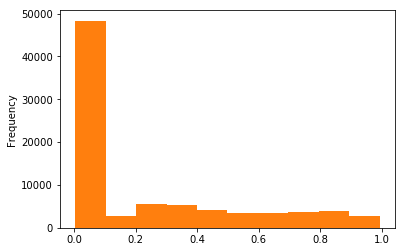

In [265]:
src_man30gu.u_prob.plot.hist()
plt.show()